Esta celda inicializa el entorno de trabajo importando todas las librerías necesarias para el proyecto. Incluye:
- _pandas_ para la manipulación de datos.
- _nltk_ para el preprocesamiento de texto (tokenización, stopwords, stemming).
- _wordcloud_ para visualización.
- _sklearn_ para la construcción de pipelines, vectorización de texto (TfidfVectorizer, CountVectorizer), reducción de dimensionalidad (TruncatedSVD, PCA), modelado (LogisticRegression, RandomForestClassifier, KNeighborsClassifier), y evaluación (classification_report, GridSearchCV).

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud



from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import TransformerMixin, BaseEstimator


from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE


__Carga y Exploración Inicial de Datos__
Carga el dataset desde el archivo Train_textosODS.xlsx. Se crea una copia (_data_) para trabajar sobre ella sin modificar el original.

In [123]:
raw_data = pd.read_excel('Train_textosODS.xlsx')
data = raw_data.copy()
data.head()

,textos,ODS
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,No dejar clara la naturaleza de estos riesgos ...,6
2,"Como resultado, un mayor y mejorado acceso al ...",13
3,Con el Congreso firmemente en control de la ju...,16
4,"Luego, dos secciones finales analizan las impl...",5


__Split del dataset__ se dividen los datos en entrenamiento y pruebas 80/20, así se garantiza que el modelo se evalúe con textos que no ha visto durante el aprendizaje, asegurando una medida objetiva de su capacidad de generalización.

In [124]:
x_train, x_test, y_train, y_test = train_test_split(data['textos'], data['ODS'], test_size=0.2, random_state=42)  

__Descarga de Recursos para Preprocesamiento__ Se descargan las _stopwords?, que es el corpus de palabras con bajo valor semantico que provee nltk. 

Es un paso preparatorio indispensable para la limpieza de los textos que se realizará dentro del pipeline

In [125]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I508111/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

__Definición de Estrategias__ Se define un diccionario que parametriza el pipeline para obtener las bolsas de palabras, a la vez es la parte experimental en la reducción de dimensionalidad.

Cada diccionario representa una combinación única de vectorización de texto (count para Bag-of-Words o tfidf para TF-IDF) y una técnica de reducción de dimensionalidad (svd o pca). Esto permite probar y comparar sistemáticamente cuatro pipelines de preparación de datos, lo cual es fundamental para justificar la elección final del método, como lo solicita el proyecto.

Igualmente, cada diccionario define placeholders para almacenar los datos de entrenamiento y pruebas resultantes de la transformación.

In [126]:
bow_list =[
    {
        "vectorized": "count",
        "reduction": "svd",
        "train_data": None,
        "test_data": None
    },
    {
        "vectorized": "tfidf",
        "reduction": "svd",
        "train_data": None,
        "test_data": None
    },
    {
        "vectorized": "count",
        "reduction": "pca",
        "train_data": None,
        "test_data": None
    },
    {
        "vectorized": "tfidf",
        "reduction": "pca",
        "train_data": None,
        "test_data": None
    }
]

__Preprocesador de Texto__ Esta clase que hereda de BaseEstimator y TransformerMixin de sklearn para ser compatible con los pipelines, encapsula los pasos de preprocesamiento de texto:
1. Tokenización: Divide el texto en palabras (RegexpTokenizer).
2. Eliminación de Stopwords: Filtra las palabras de bajo valor semántico del Español.
3. Stemming: Reduce las palabras a su raíz (PorterStemmer). 

Este transformador es el primer paso del pipeline de preparación de datos.

In [127]:
class TextPreprocessorTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):            
        return X.apply(self.text_preprocess)
    
    def text_preprocess(self, text):
        tokenizer = RegexpTokenizer(r'\w+')
        stemmer = PorterStemmer()
    
        tokens = tokenizer.tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('spanish')]
        tokens = [stemmer.stem(word) for word in tokens]
        return ' '.join(tokens)

__Transformador a Matriz Densa__ La clase ToDenseTransformer se crea como un paso auxiliar dentro del pipeline. La salida de los vectorizadores de texto suele ser una matriz dispersa (sparse matrix) para ahorrar memoria. Sin embargo, el algoritmo PCA de sklearn requiere una matriz densa como entrada.

Este transformador se encarga de realizar esta conversión, permitiendo que PCA funcione correctamente dentro del pipeline.

In [128]:
class ToDenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.toarray()

__Factory de Pipelines__ Esta clase construye el objeto Pipeline son sus respecivos pasos para preparar los datos, utiliza las clases previamente definidas y se basa en los parámetros de vectorización ('count' o 'tfidf') y reducción ('svd' o 'pca'):
1. El preprocesamiento de texto (TextPreprocessorTransformer).
2. La vectorización (usando CountVectorizer o TfidfVectorizer).
3. La reducción de dimensionalidad (usando TruncatedSVD o PCA).
    - TruncatedSVD es la base del Análisis Semántico Latente (LSI), una técnica que proyecta documentos y palabras en un espacio de baja dimensión para descubrir conceptos semánticos. 
    - Ó, PCA como otro método de extracción de características que logra un fin similar.

In [129]:
class DataProcessingPipelineFactory:
    def get_pipelines_and_params(self, vectorizer, reduction):        

        steps = [
            ('preprocess', TextPreprocessorTransformer())             
        ]
        if vectorizer == 'count':
            steps.append(('vectorizer', CountVectorizer()))
        if vectorizer == 'tfidf':
            steps.append(('vectorizer', TfidfVectorizer()))
        if reduction == 'svd':
            steps.append(('dimred', TruncatedSVD(n_components=100)))
        if reduction == 'pca':
            steps.append(('to_dense', ToDenseTransformer()))             
            steps.append(('dimred', PCA(n_components=100)))            

        pipeline = Pipeline(steps)
        return pipeline

__Ejecución del pipeline y almacenamiento de resultados__ se recorre la lista bow_list que parametriza la creación de bolsas de palabras. En cada iteración, utiliza el factory de pipelines, los construye, y los aplica a los datos de entrenamiento (fit_transform) y prueba (transform).

Los datos transformados (con las características reducidas) se almacenan de nuevo en cada bolsa de palabras, así quedan listos para ser usados por los modelos de clasificación.

In [130]:
for bow in bow_list:
    pipeline = DataProcessingPipelineFactory().get_pipelines_and_params(bow['vectorized'], bow['reduction'])    
    bow['train_data'] = pipeline.fit_transform(x_train)
    bow['test_data'] = pipeline.transform(x_test)

__Aplicación de t-SNE__ Con t-SNE se puede visualizar la separabilidad de las clases después de la reducción de dimensionalidad. Se recorren cada uno de los cuatro datasets transformados, reduciendo sus 100 dimensiones a solo 2, para ser graficadas.

Esta visualización ayuda a entender la estructura de los datos y la efectividad de cada pipeline de preprocesamiento.

__TODO__: detallar un poco cada grafica ----  Gráfica de los Resultados de t-SNE Esta celda genera una matriz de 2x2 gráficos, donde cada gráfico muestra la proyección t-SNE de uno de los cuatro pipelines de preparación de datos. Los puntos están coloreados según su ODS real. Esto permite una comparación visual directa para determinar qué combinación de vectorización y reducción de dimensionalidad agrupa mejor los textos de la misma categoría.

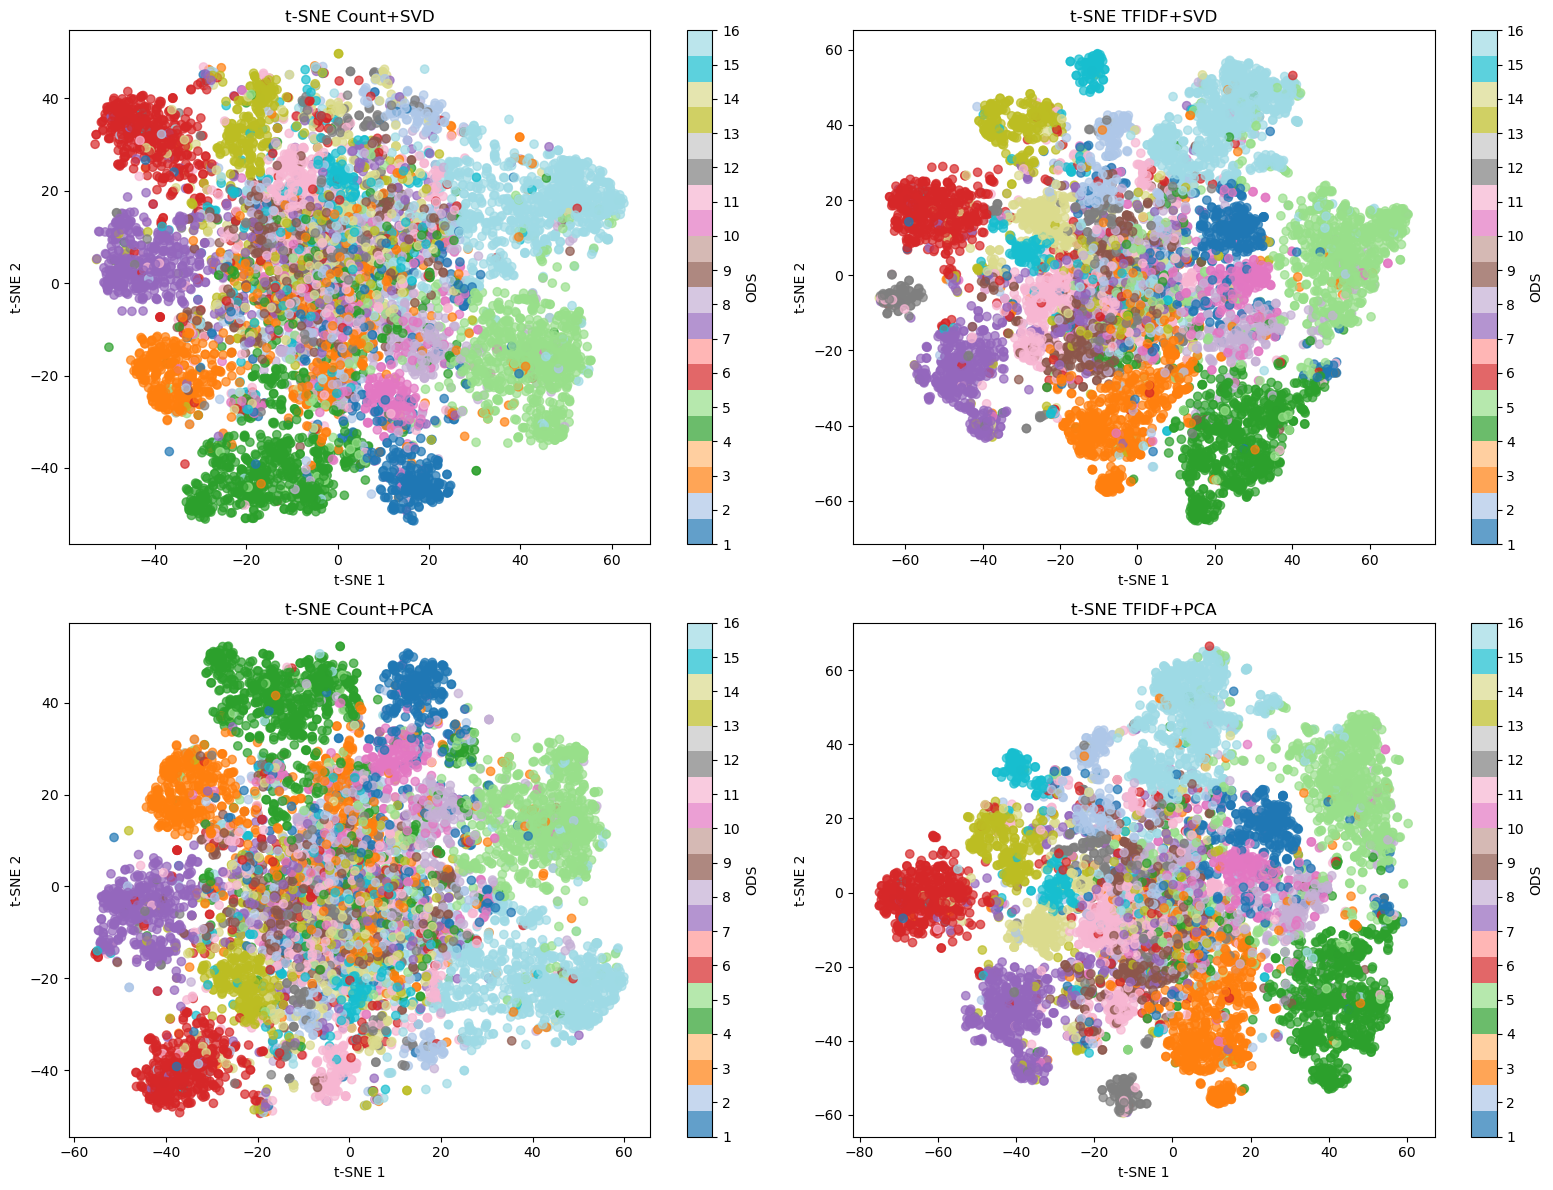

In [131]:
nombres = ['Count+SVD', 'TFIDF+SVD', 'Count+PCA', 'TFIDF+PCA']
labels = y_train.astype(int)

tsne_results = []
for bow in bow_list:
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(bow['train_data'])
    tsne_results.append(tsne_result)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for i, ax in enumerate(axes.flat):
    scatter = ax.scatter(tsne_results[i][:,0], tsne_results[i][:,1], c=labels, cmap='tab20', alpha=0.7)
    ax.set_title(f't-SNE {nombres[i]}')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    cbar = plt.colorbar(scatter, ax=ax, ticks=range(1,17))
    cbar.set_label('ODS')

plt.tight_layout()
plt.show()

__Factory de Pipelines para los Modelos de Clasificación__ De manera análoga a la fábrica de datos, esta clase se encarga de construir el pipeline para el modelo de clasificación y definir una configuración de hiperparámetros para la optimización (param_grid).

Soporta tres algoritmos: LogisticRegression, RandomForestClassifier y KNeighborsClassifier. Este enfoque modular facilita la prueba y comparación de diferentes algoritmos, esto permite contrastar los diferentes modelos de clasificación.

In [132]:
class ModelPipelineFactory:
    def get_pipelines_and_params(self, algorithm):

        if algorithm == 'logistic':
            model = LogisticRegression(max_iter=2000)
            param_grid = {
                'model__C': [0.1, 1, 10],
                'model__solver': ['lbfgs', 'saga']
            }
        elif algorithm == 'randomforest':
            model = RandomForestClassifier()
            param_grid = {
                'model__n_estimators': [100, 200],
                'model__max_depth': [None, 10, 20]
            }
        elif algorithm == 'kneighbors':
            model = KNeighborsClassifier()
            param_grid = {
                'model__n_neighbors': [3, 5, 7],
                'model__weights': ['uniform', 'distance']
            }
        else:
            raise ValueError(f"Algoritmo no soportado: {algorithm}")

        steps = [
            ('model', model)            
        ]

        pipeline = Pipeline(steps)
        return pipeline, param_grid

__Función helper para visualizar la Evaluación__ esta función estandariza la visualización de los resultados de aplicar un algoritmos de clasificación a una bolsa de palabras. Recibe las etiquetas verdaderas y las predicciones, y genera dos visualizaciones:
1. Un reporte de clasificación (classification_report) que muestra métricas como precisión, recall y f1-score por cada clase.
2. Una matriz de confusión (confusion_matrix) que visualiza los aciertos y errores del modelo. Esta función es clave para cumplir con el requisito de evaluación del modelo

In [133]:
def print_reports(y_test, y_pred, title):    
    # Reporte de clasificación como tabla
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Tabla de reporte de clasificación
    ax1.axis('off')
    table = ax1.table(cellText=df_report.round(2).values,
                    colLabels=df_report.columns,
                    rowLabels=df_report.index,
                    loc='center',
                    cellLoc='center')
    ax1.set_title('Reporte de Clasificación: ' + title)

    # Matriz de confusión con ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax2, cmap=plt.cm.Blues)
    ax2.set_title('Matriz de Confusión')

    plt.tight_layout()
    plt.show()

In [ ]:
algorithms = ['logistic', 'randomforest', 'kneighbors']
#algorithms = ['kneighbors']


__Ciclos de Entrenamiento, Optimización y Evaluación__ Este es el núcleo del proyecto, donde se unen todos los componentes anteriores. Ejecuta cada algoritmo de clasificación para cada una de las bolsas de palabras preparadas previamente:
1. Optimización: Utiliza GridSearchCV para encontrar la mejor combinación de hiperparámetros para cada modelo, usando validación cruzada de 3 subconjuntos (folds). Esta es la búsqueda de hiperparámetros.
2. Entrenamiento: El GridSearchCV entrena el modelo con los mejores hiperparámetros encontrados.
3. Evaluación: Realiza predicciones sobre el conjunto de prueba (que son los datos no vistos) y utiliza la función helper para visualizar el rendimiento final.

Los resultados impresos muestran que la combinación de regresión logística con vectorización TF-IDF y reducción de dimensionalidad PCA obtiene el mejor score de validación (0.8600), justificando empíricamente su elección como el mejor modelo.

__TODO__: Detallar cada resultado.

ENTRENAMIENTO Y EVALUACION PARA: logistic con count + svd
Mejores hiperparámetros: {'model__C': 0.1, 'model__solver': 'lbfgs'}
Mejor score de validación: 0.8048937973209819


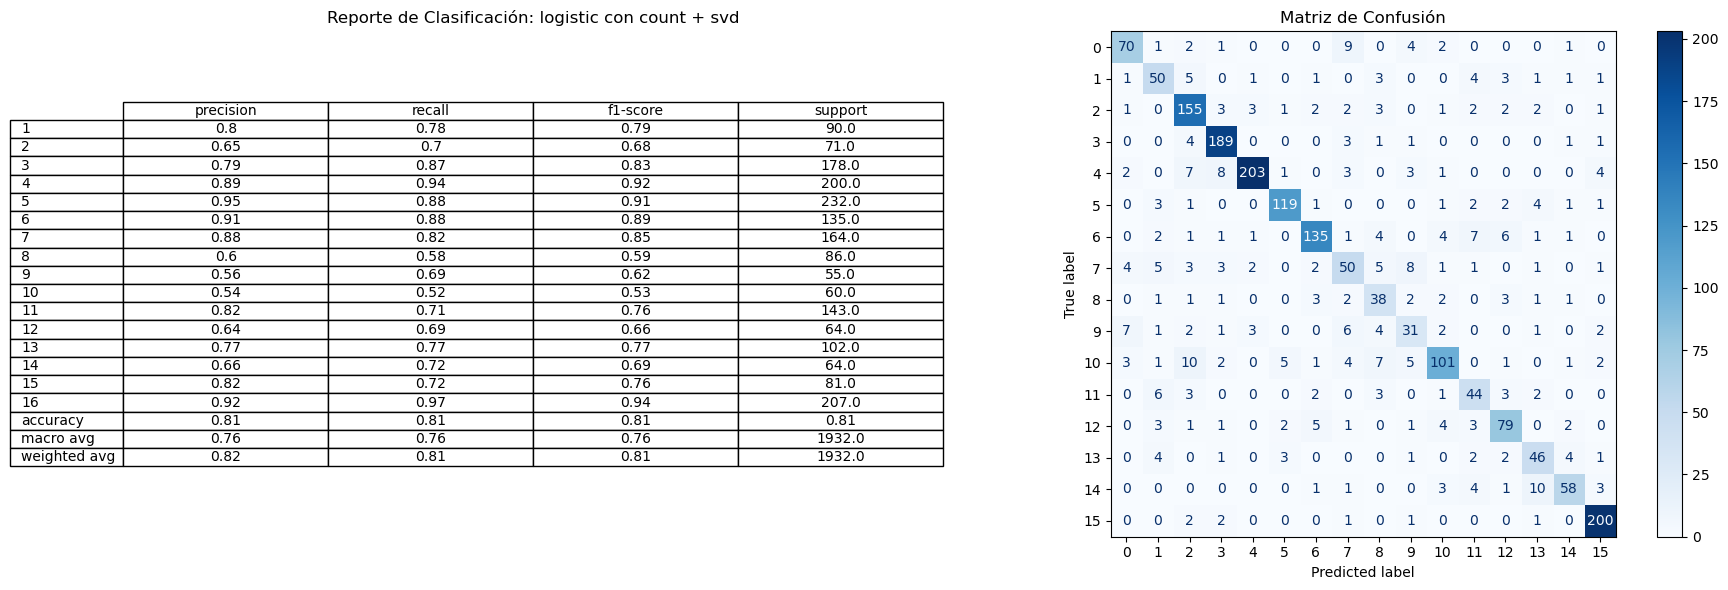

ENTRENAMIENTO Y EVALUACION PARA: logistic con tfidf + svd
Mejores hiperparámetros: {'model__C': 10, 'model__solver': 'lbfgs'}
Mejor score de validación: 0.858234422894617


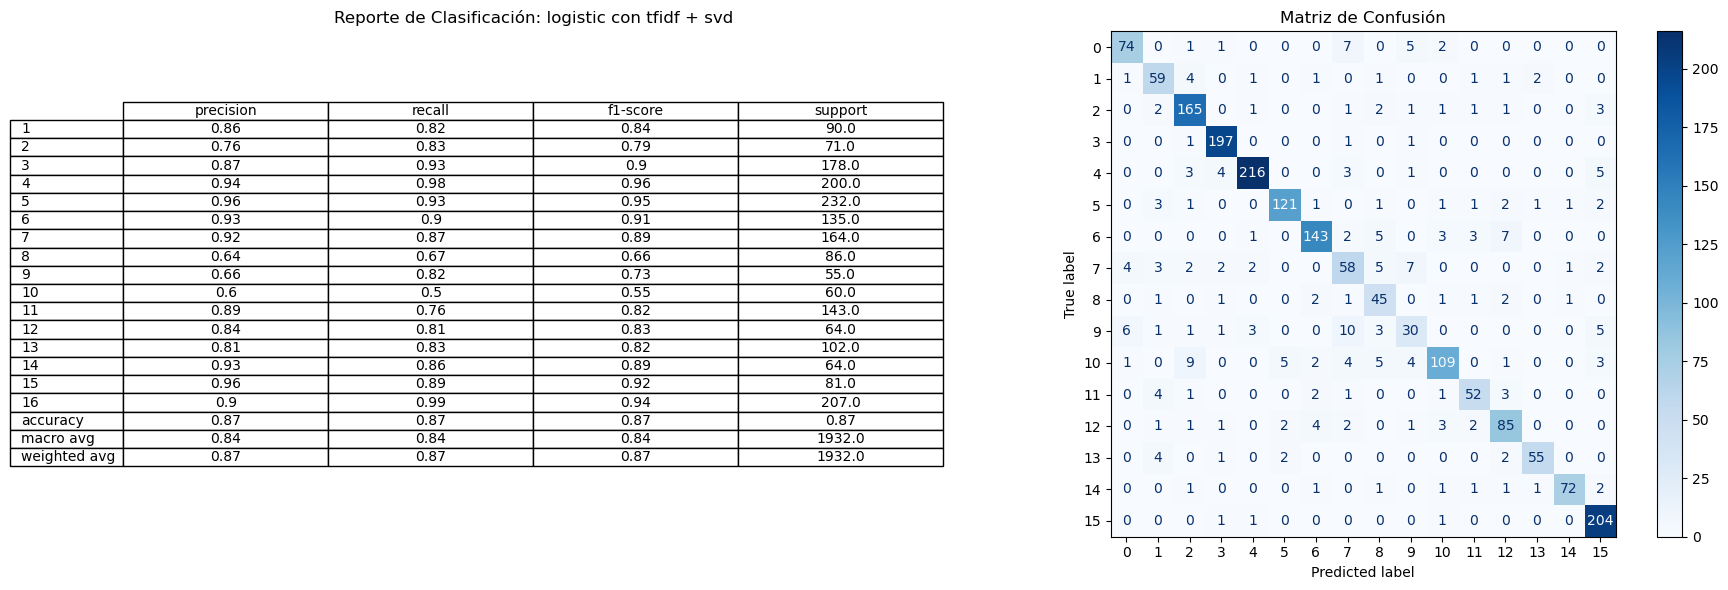

ENTRENAMIENTO Y EVALUACION PARA: logistic con count + pca


/Users/I508111/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/I508111/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mejores hiperparámetros: {'model__C': 0.1, 'model__solver': 'saga'}
Mejor score de validación: 0.8016572496184148


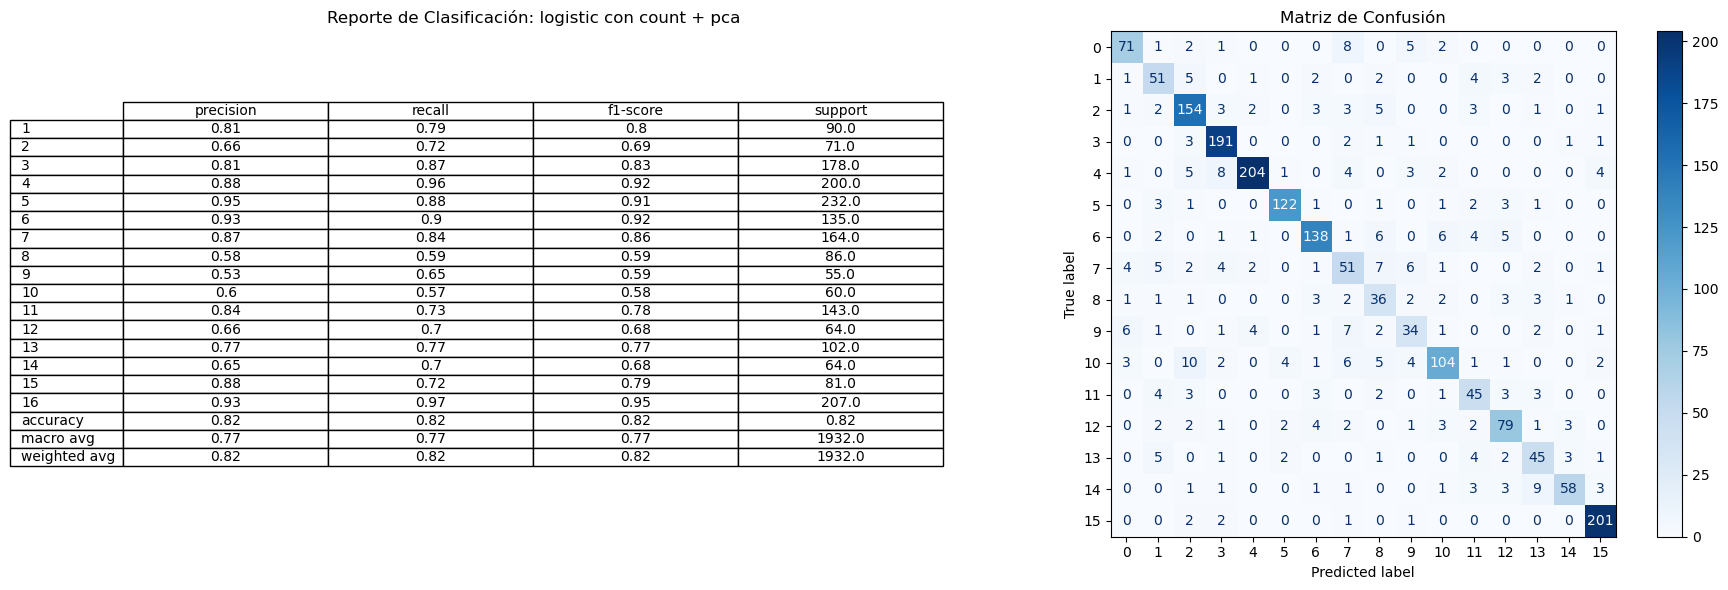

ENTRENAMIENTO Y EVALUACION PARA: logistic con tfidf + pca
Mejores hiperparámetros: {'model__C': 10, 'model__solver': 'saga'}
Mejor score de validación: 0.8600470223771195


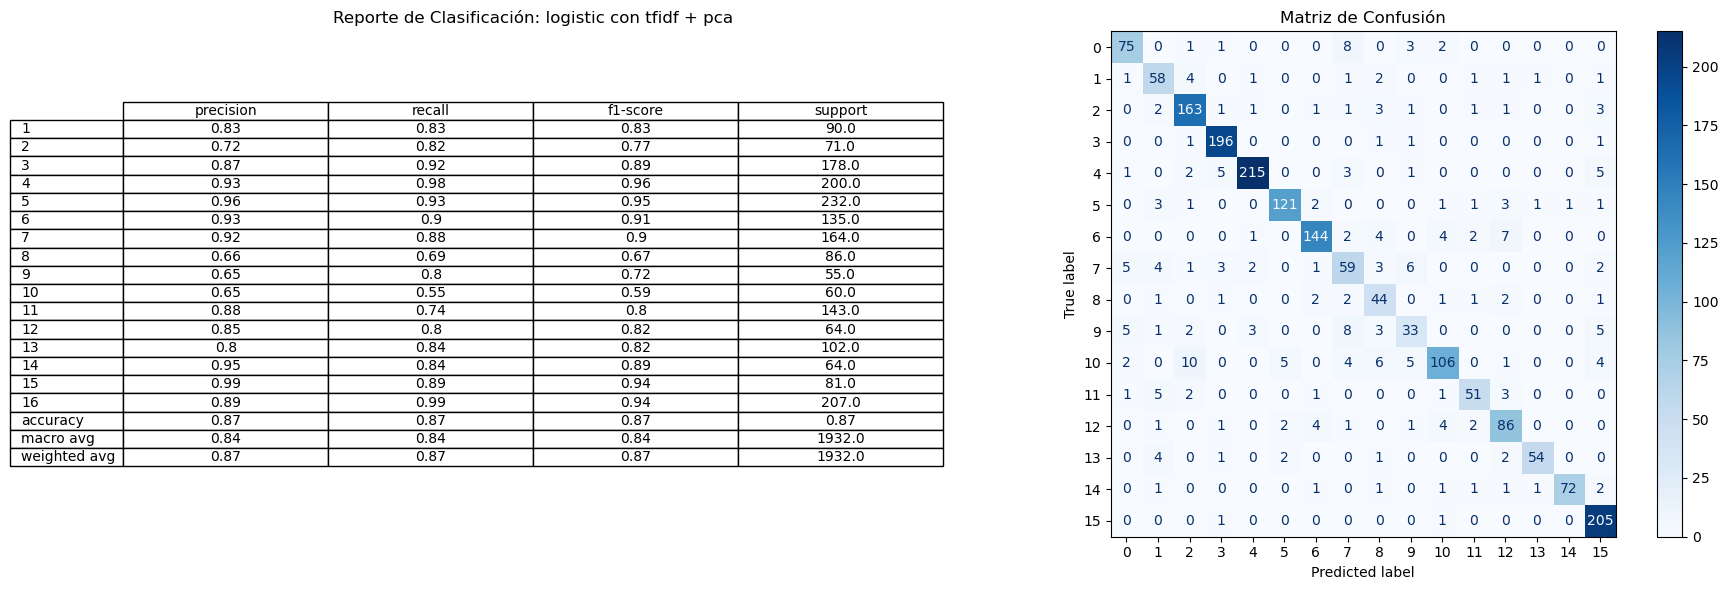

ENTRENAMIENTO Y EVALUACION PARA: randomforest con count + svd
Mejores hiperparámetros: {'model__max_depth': None, 'model__n_estimators': 200}
Mejor score de validación: 0.7428800325887704


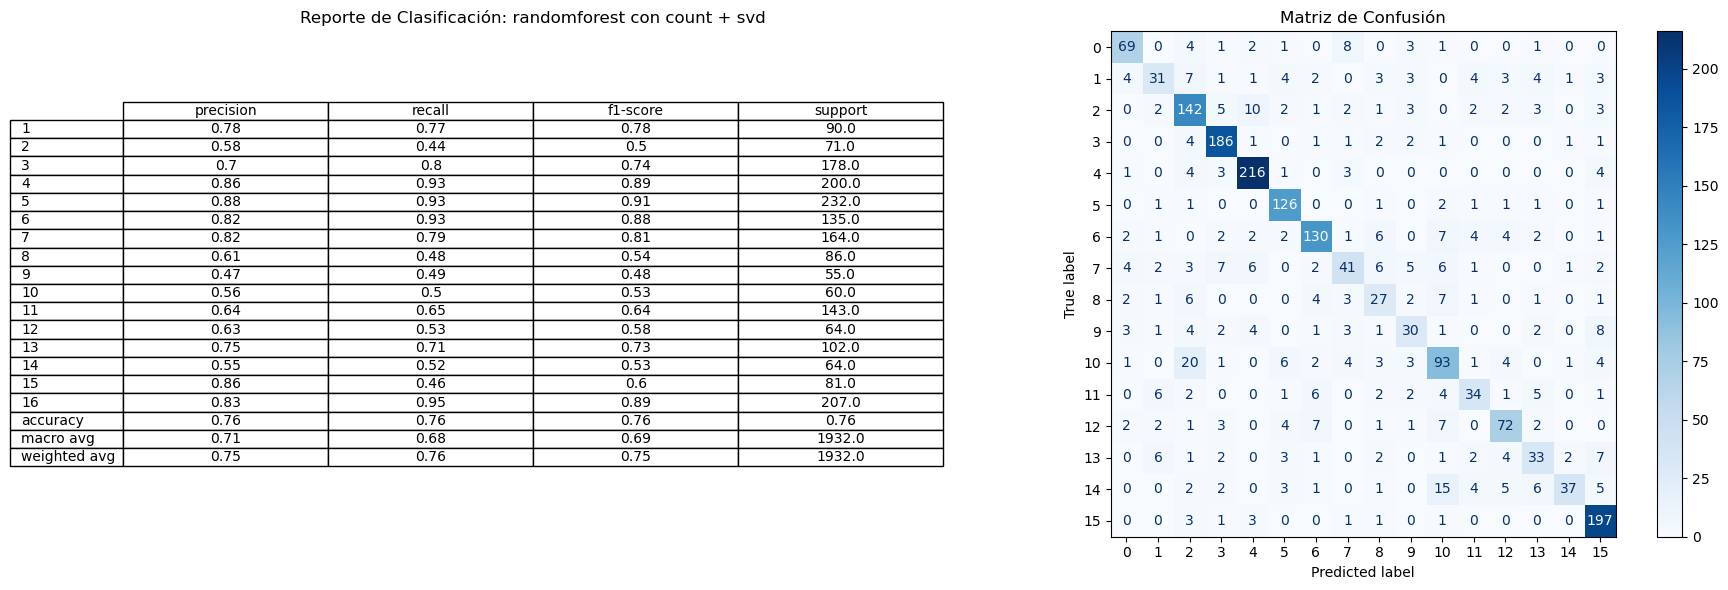

ENTRENAMIENTO Y EVALUACION PARA: randomforest con tfidf + svd
Mejores hiperparámetros: {'model__max_depth': None, 'model__n_estimators': 200}
Mejor score de validación: 0.8241839354460714


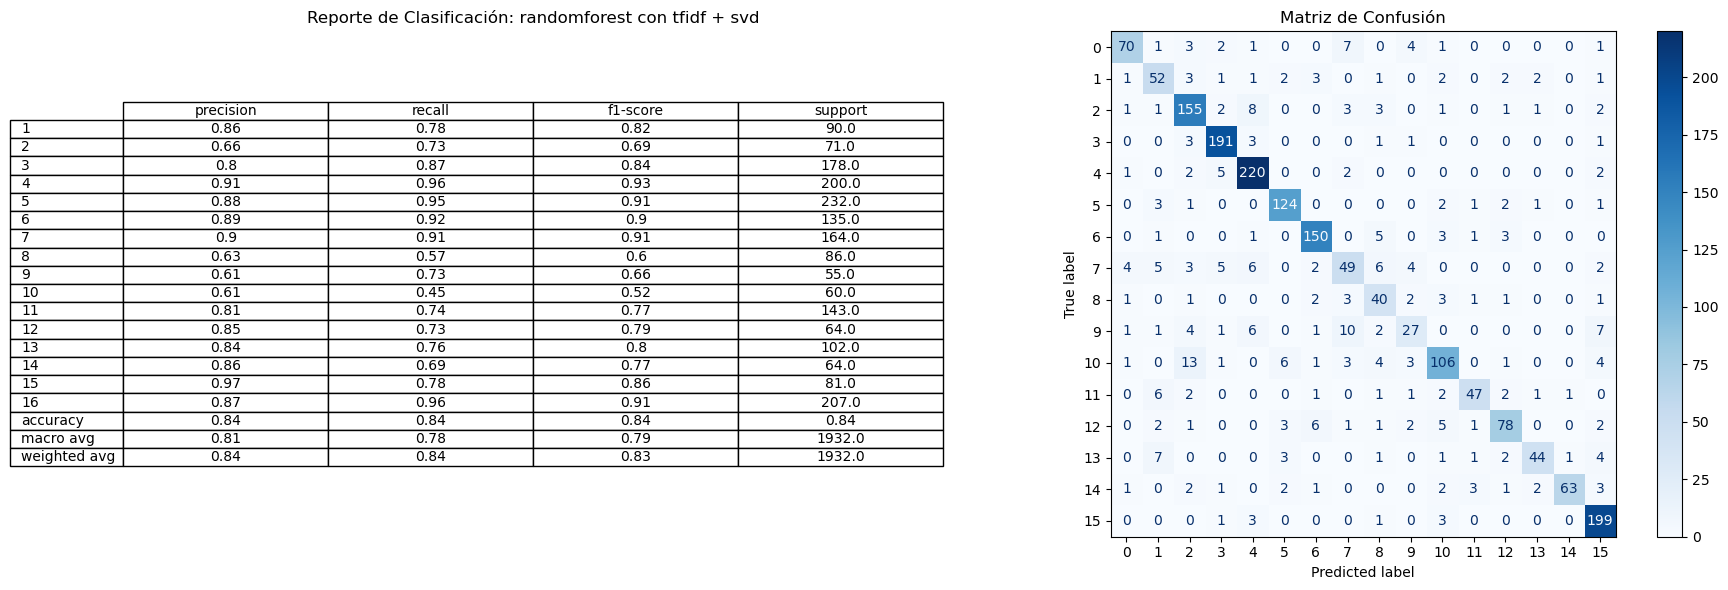

ENTRENAMIENTO Y EVALUACION PARA: randomforest con count + pca
Mejores hiperparámetros: {'model__max_depth': None, 'model__n_estimators': 200}
Mejor score de validación: 0.7339457809360722


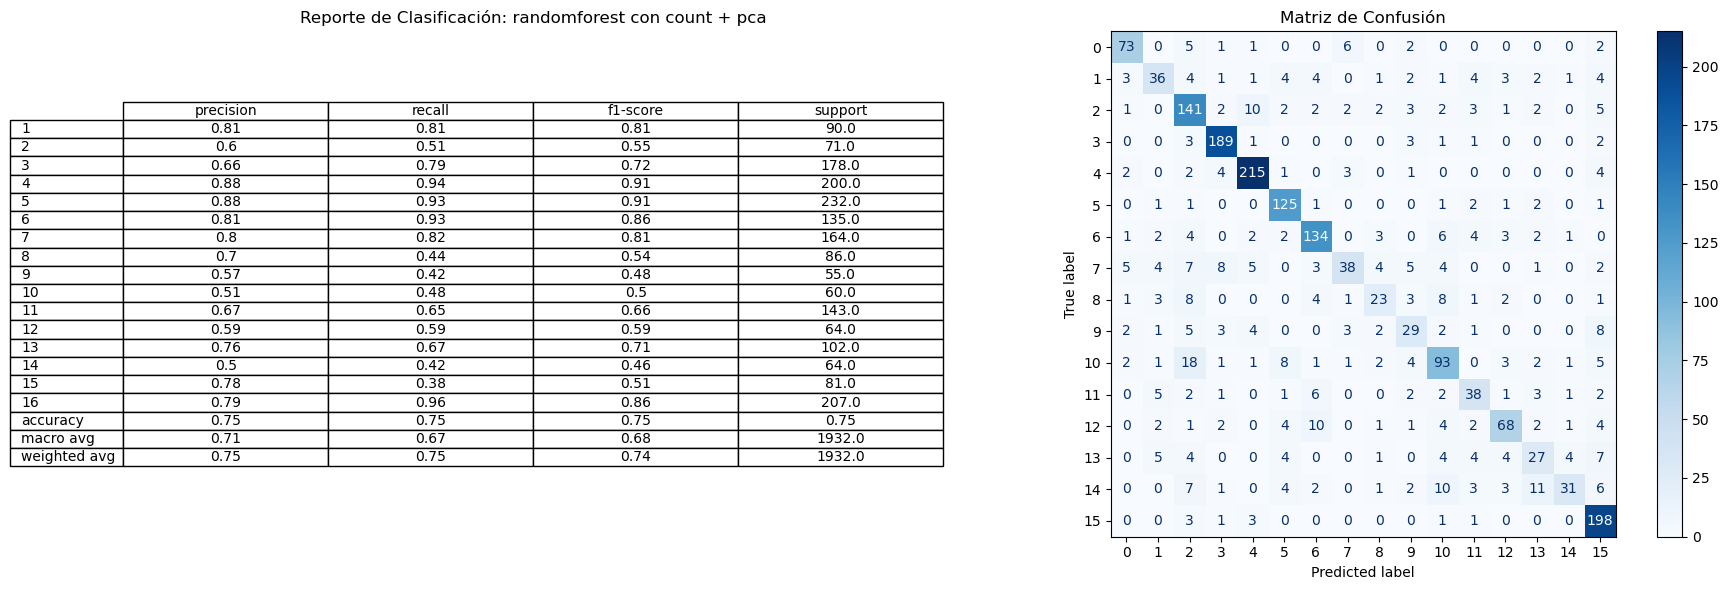

ENTRENAMIENTO Y EVALUACION PARA: randomforest con tfidf + pca
Mejores hiperparámetros: {'model__max_depth': None, 'model__n_estimators': 200}
Mejor score de validación: 0.8258679400426973


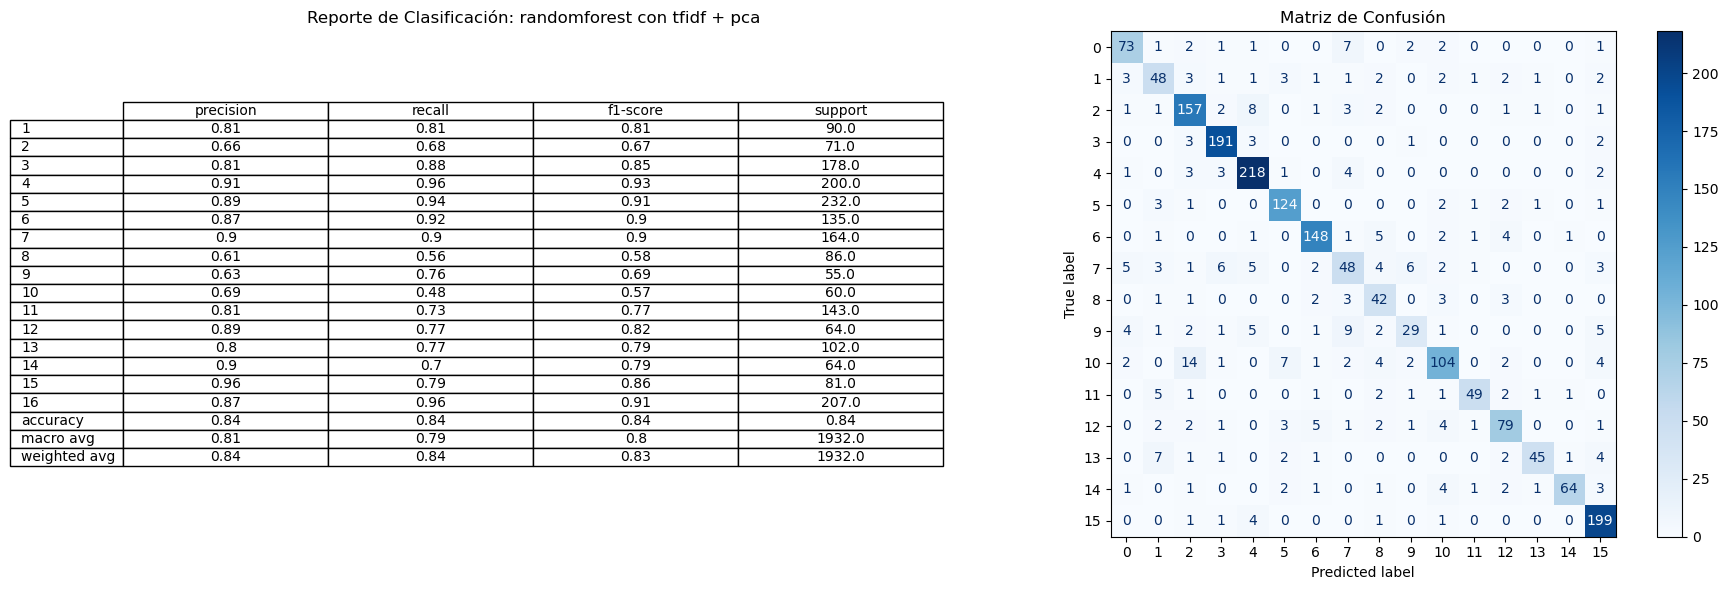

ENTRENAMIENTO Y EVALUACION PARA: kneighbors con count + svd
Mejores hiperparámetros: {'model__n_neighbors': 7, 'model__weights': 'distance'}
Mejor score de validación: 0.6418952784001327


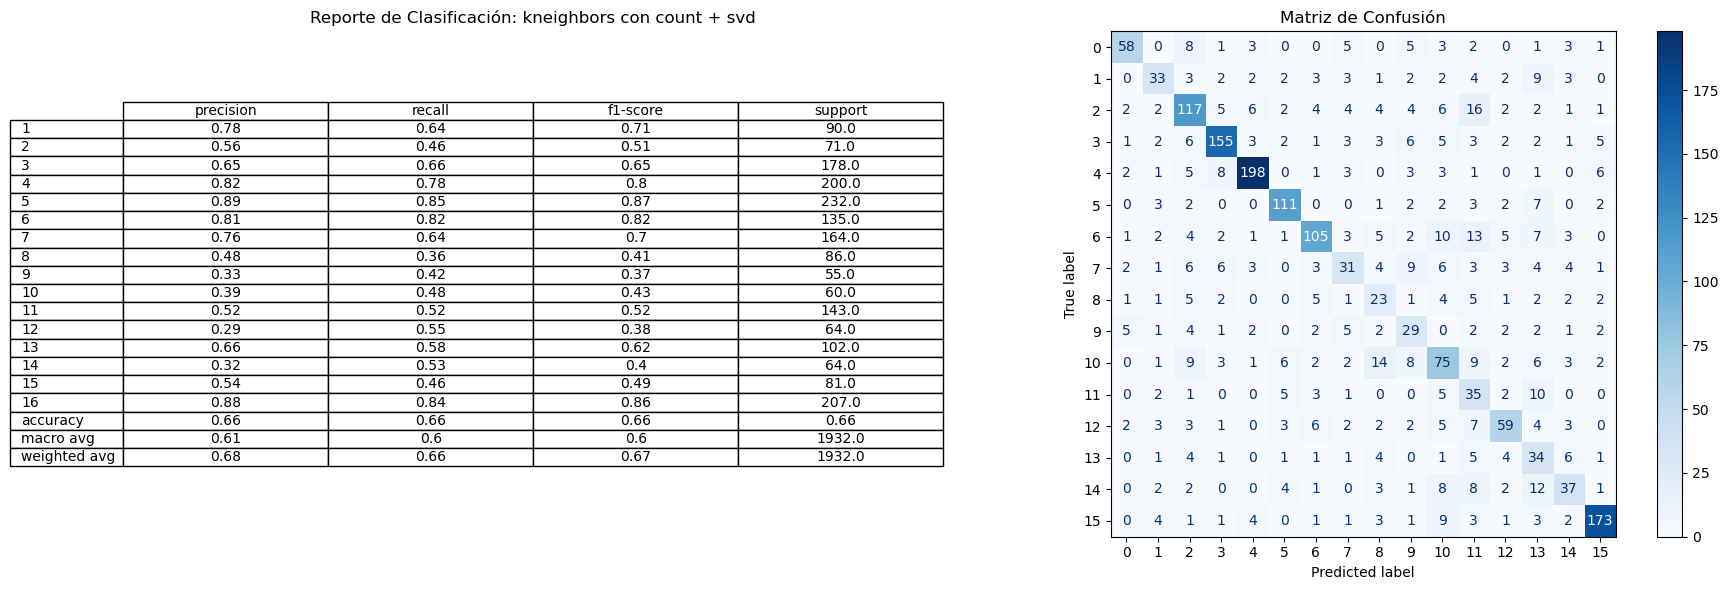

ENTRENAMIENTO Y EVALUACION PARA: kneighbors con tfidf + svd
Mejores hiperparámetros: {'model__n_neighbors': 7, 'model__weights': 'distance'}
Mejor score de validación: 0.7752461634015032


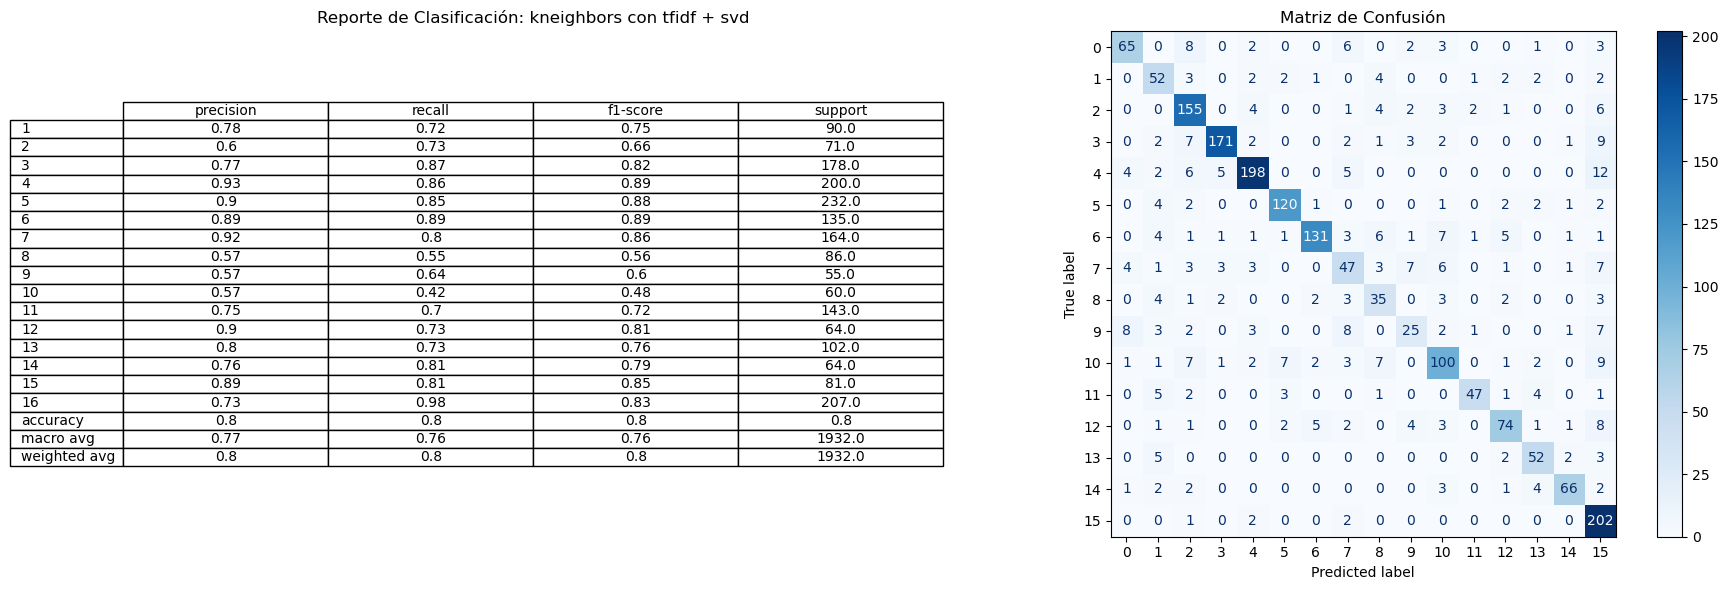

ENTRENAMIENTO Y EVALUACION PARA: kneighbors con count + pca
Mejores hiperparámetros: {'model__n_neighbors': 7, 'model__weights': 'distance'}
Mejor score de validación: 0.6378824339989388


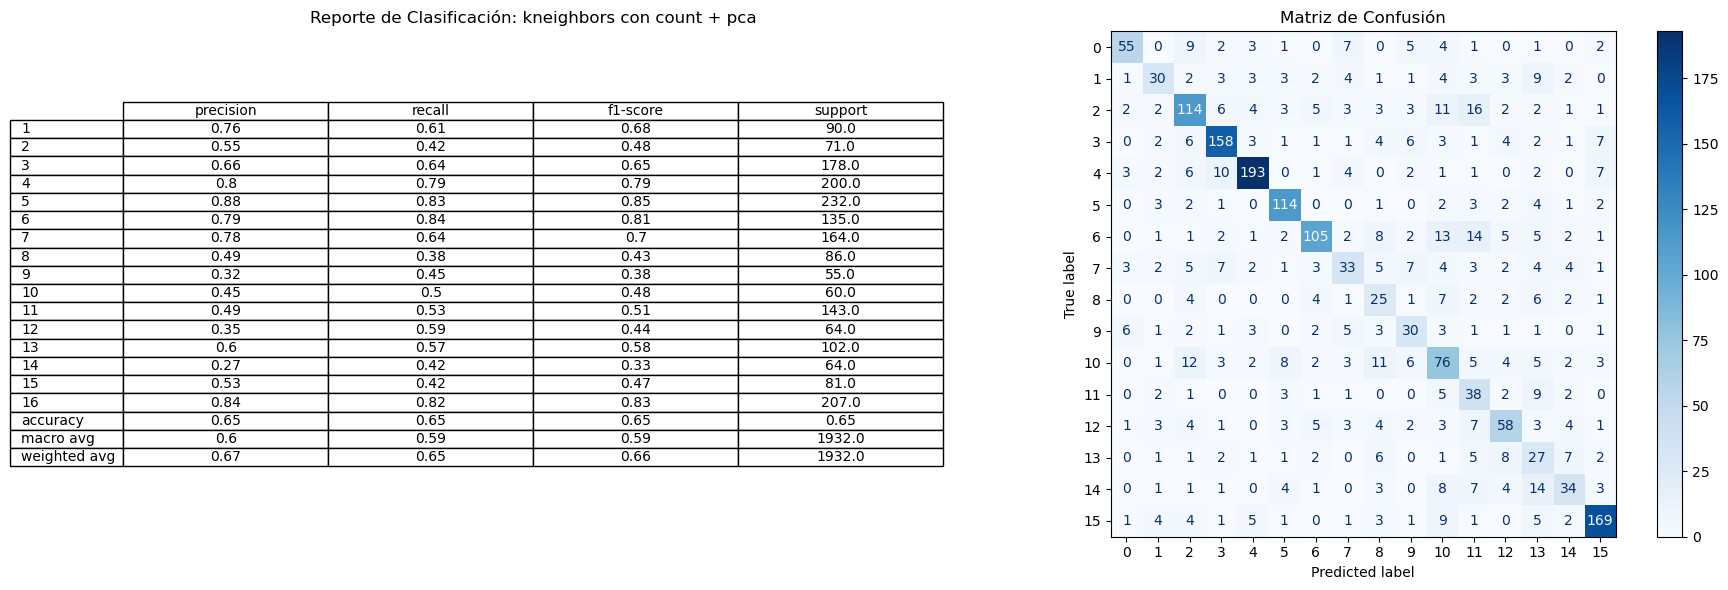

ENTRENAMIENTO Y EVALUACION PARA: kneighbors con tfidf + pca
Mejores hiperparámetros: {'model__n_neighbors': 7, 'model__weights': 'distance'}
Mejor score de validación: 0.7687732188703063


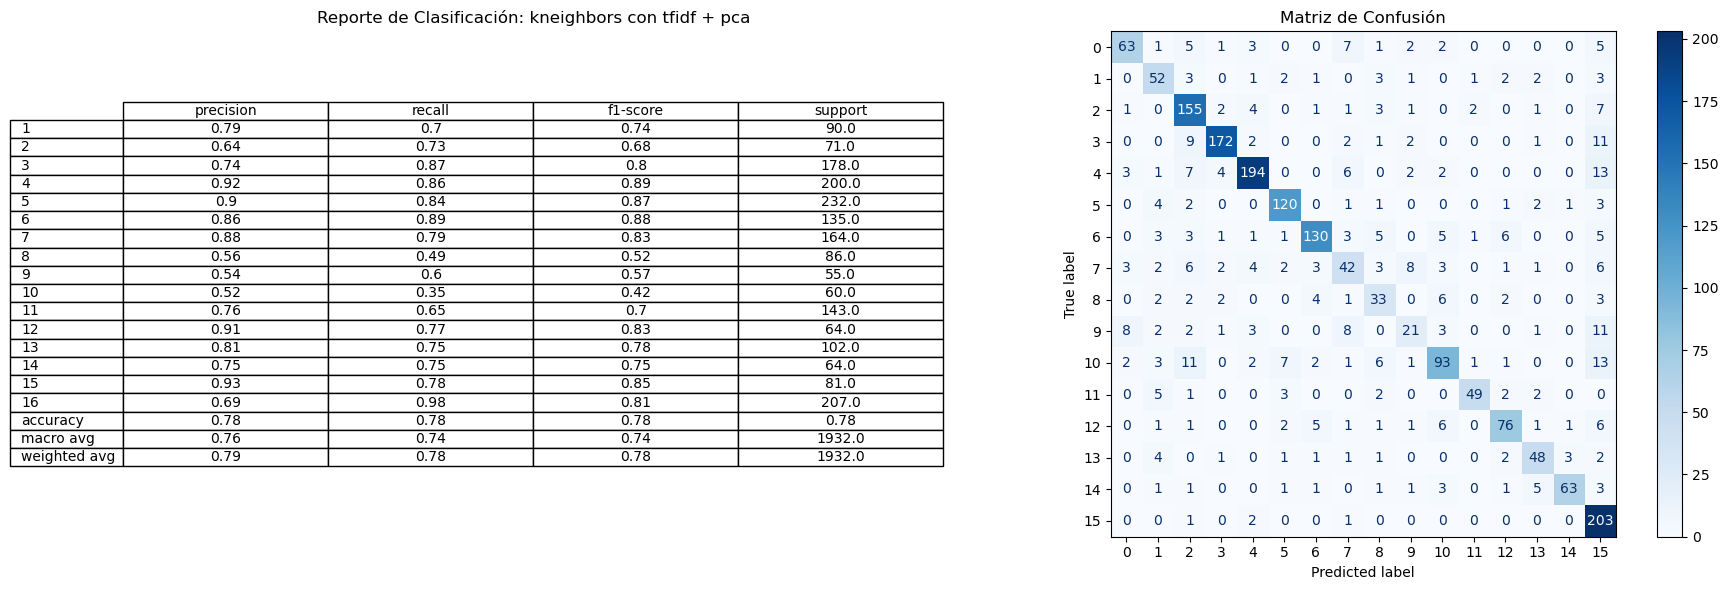

In [135]:
for algorithm in algorithms:
    for bow in bow_list:
        title = f"{algorithm} con {bow['vectorized']} + {bow['reduction']}"
        print("ENTRENAMIENTO Y EVALUACION PARA:", title)
        pipelineFactory = ModelPipelineFactory()
        pipeline, params = pipelineFactory.get_pipelines_and_params(algorithm)
        grid = GridSearchCV(pipeline, params, cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(bow['train_data'], y_train)
        print("Mejores hiperparámetros:", grid.best_params_)
        print("Mejor score de validación:", grid.best_score_)
        
        y_pred = grid.predict(bow['test_data'])
        
        print_reports(y_test, y_pred, title)     
        

En este proyecto se desarrolló una solución de machine learning para clasificar textos según los 17 Objetivos de Desarrollo Sostenible (ODS), abordando la necesidad de automatizar el análisis de información textual para organizaciones como la UNFPA.

El trabajo se estructuró mediante pipelines de sklearn que integraron sistemáticamente varias etapas. Primero, se realizó un preprocesamiento de texto que incluyó tokenización, eliminación de stopwords y stemming. Posteriormente, se representaron los textos numéricamente utilizando el esquema de bolsa de palabras (BOW), probando tanto la ponderación TF-IDF como el conteo simple de frecuencias.

Un aspecto central fue la reducción de la dimensionalidad, un requisito clave para manejar la complejidad de los datos textuales y mejorar el rendimiento de los modelos. Para ello, se aplicaron y compararon dos técnicas de extracción de características: Análisis de Componentes Principales (PCA) y Descomposición en Valores Singulares (SVD), la cual es la base del Análisis Semántico Latente (LSI). Finalmente, se entrenaron y optimizaron tres algoritmos de clasificación distintos (LogisticRegression, RandomForestClassifier y KNeighborsClassifier) mediante una búsqueda exhaustiva de hiperparámetros con GridSearchCV.

Los resultados de este proceso experimental muestran que el enfoque fue efectivo. La evaluación las combinaciones de vectorización, reducción de dimensionalidad y algoritmos de clasificación permitió identificar una configuración óptima con base en evidencia empírica. El modelo con el mejor desempeño fue el de Regresión Logística, que alcanzó un score de validación del 86%. Este resultado se obtuvo al combinar la representación vectorial de textos mediante TF-IDF con la técnica de reducción de dimensionalidad PCA.

La conclusión principal es que la extracción de características como PCA o SVD es fundamental para transformar la representación de alta dimensionalidad de los textos en un espacio semántico de menor dimensionalidad. Esta nueva representación, que captura conceptos en lugar de términos aislados, permitió que el modelo de clasificación alcanzara un alto rendimiento, cumpliendo con éxito el objetivo de construir una solución consistente para la clasificación automática de textos en el contexto de los ODS.